In [43]:
import torch
from torchvision import datasets, transforms
from torch import tensor
import random
from torchvision.transforms import functional as F

In [44]:
%matplotlib inline

In [45]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [46]:
cpu_device = torch.device("cpu")

In [47]:
#Defining custom transformations to match fastai's aug_transforms https://docs.fast.ai/vision.augment.html#aug_transforms

class RandomFlip:
    def __init__(self, horizontal=True, vertical=False, p=0.5):
        self.horizontal = horizontal
        self.vertical = vertical
        self.p = p
    
    def __call__(self, img):
        if self.horizontal and random.random() < self.p:
            img = F.hflip(img)
        if self.vertical and random.random() < self.p:
            img = F.vflip(img)
        return img
    
class RandomRotate:
    def __init__(self, degrees=10):
        self.degrees = degrees

    def __call__(self, img):
        angle = random.uniform(-self.degrees, self.degrees)
        return F.rotate(img, angle)
    
class RandomResizedCrop:
    def __init__(self, size, scale=(0.75, 1.0), ratio=(3/4, 4/3)):
        self.size = size
        self.scale = scale
        self.ratio = ratio

    def __call__(self, img):
        i, j, h, w = transforms.RandomResizedCrop.get_params(img, self.scale, self.ratio)
        return F.resized_crop(img, i, j, h, w, self.size)
    
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2)

class RandomWarp:
    def __init__(self, distortion_scale=0.2, p=0.75):
        self.distortion_scale = distortion_scale
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            width, height = F.get_image_size(img)
            startpoints, endpoints = self._get_perspective_params(width, height)
            return F.perspective(img, startpoints, endpoints, interpolation=F.InterpolationMode.BILINEAR)
        return img
    
    def _get_perspective_params(self, width, height):
        startpoints = [
            (0, 0), (width, 0), (width, height), (0, height)
        ]

        distortion = self.distortion_scale * min(width, height)
        endpoints = [
            (random.uniform(0, distortion), random.uniform(0, distortion)),
            (width - random.uniform(0, distortion), random.uniform(0, distortion)),
            (width - random.uniform(0, distortion), height - random.uniform(0, distortion)),
            (random.uniform(0, distortion), height - random.uniform(0, distortion))
        ]
        return startpoints, endpoints

In [7]:
train_transform = transforms.Compose([
    RandomFlip(horizontal=True, vertical=False, p=0.5),
    RandomRotate(degrees=10),
    RandomResizedCrop(size=(224, 224), scale=(0.75, 1.1)),
    color_jitter,
    RandomWarp(distortion_scale=0.2, p=0.75),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
valid_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])

In [48]:
from torchvision.datasets import OxfordIIITPet
import os
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from sklearn.model_selection import train_test_split
import re
from torchvision.transforms import functional as F

path = Path('./data/oxford-iiit-pet/images')

full_dataset = OxfordIIITPet(root="data", target_types="category", download=True)

image_files = [full_dataset._images[i] for i in range(len(full_dataset))]
labels = [full_dataset._labels[i] for i in range(len(full_dataset))]

train_files, valid_files, train_labels, valid_labels = train_test_split(
    image_files, labels, test_size=0.2, random_state=42
)



class PetsDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        image = datasets.folder.default_loader(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label
    
#image_files = get_image_files(path)
#labels = [label_func(f) for f in image_files]

train_files, valid_files, train_labels, valid_labels = train_test_split(
    image_files, labels, test_size=0.2, random_state=42
)

assert len(train_files) == len(train_labels), "Mismatch between training files and labels"
assert len(valid_files) == len(valid_labels), "Mismatch between validation files and labels"

item_transform = transforms.Compose([
    transforms.Resize((460, 460)),  # Resize all images to 460x460
    transforms.ToTensor()           # Convert to tensor
])

# def train_batch_transform(batch):
#     #print("Batch:", batch)
#     def random_resized_crop(image, size, scale=(0.75, 1.0)):
#         i, j, h, w = transforms.RandomResizedCrop.get_params(image, scale = scale, ratio=(3/4, 4/3))
#         return F.resized_crop(image, i, j, h, w, size, interpolation=transforms.InterpolationMode.BILINEAR)
#     images, labels = zip(*batch)
#     images = [F.normalize(random_resized_crop(img, (224, 224), scale=(0.75, 1.0)),
#                            mean=[0.5]*3, std=[0.5]*3) for img in images]
#     images = torch.stack(images)
#     return images, torch.tensor(labels)

# def valid_batch_transform(batch):
#     def resize(image, size):
#         return F.resize(image, size, interpolation=transforms.InterpolationMode.BILINEAR)

#     images, labels = zip(*batch)
#     images = [F.normalize(resize(img, (224, 224)), mean=[0.5]*3, std=[0.5]*3) for img in images]
#     images = torch.stack(images)
#     return images, torch.tensor(labels)

train_dataset = PetsDataset(train_files, train_labels, transform=train_transform)
valid_dataset = PetsDataset(valid_files, valid_labels, transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)

dataloaders = {
    "train": train_loader,
    "valid": valid_loader
}


In [63]:
from torchvision.models import resnet34, ResNet34_Weights
from sklearn.metrics import accuracy_score
from torch import nn, optim
from tqdm import tqdm

model = resnet34(weights=ResNet34_Weights.DEFAULT)
unique_labels = set(labels)
num_classes = len(unique_labels) 

model = model.to(mps_device)

criterion = nn.CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

In [50]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct/total
    error_rate = 1 - accuracy
    return total_loss / len(dataloader), accuracy, error_rate

In [65]:
print("Training classification head...")
for epoch in range(1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, mps_device)
    val_loss, val_acc, val_error_rate = validate(model, valid_loader, criterion, mps_device)
    print(f"Epoch [{epoch+1}/1]: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val Error Rate={val_error_rate:.4f}")

print("Fine-tuning entire model...")
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(2):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, mps_device)
    val_loss, val_acc, val_error_rate = validate(model, valid_loader, criterion, mps_device)
    print(f"Epoch [{epoch+1}/2]: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val Error Rate={val_error_rate:.4f}")

Training classification head...


100%|██████████| 92/92 [00:29<00:00,  3.12it/s]


Epoch [1/1]: Train Loss=0.2047, Train Acc=0.9368, Val Loss=0.3135, Val Acc=0.8981, Val Error Rate=0.1019
Fine-tuning entire model...


100%|██████████| 92/92 [00:29<00:00,  3.12it/s]


Epoch [1/2]: Train Loss=0.2353, Train Acc=0.9280, Val Loss=0.3479, Val Acc=0.8818, Val Error Rate=0.1182


100%|██████████| 92/92 [00:29<00:00,  3.15it/s]


Epoch [2/2]: Train Loss=0.2002, Train Acc=0.9375, Val Loss=0.3852, Val Acc=0.8804, Val Error Rate=0.1196


In [69]:
print(model.layer1)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, mome

In [13]:
classes = full_dataset.classes

In [25]:
print(classes)

['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


Min pixel value  -0.8980392217636108
Max pixel value  0.9921568632125854
Min pixel value  0.05098038911819458
Max pixel value  0.9960784316062927


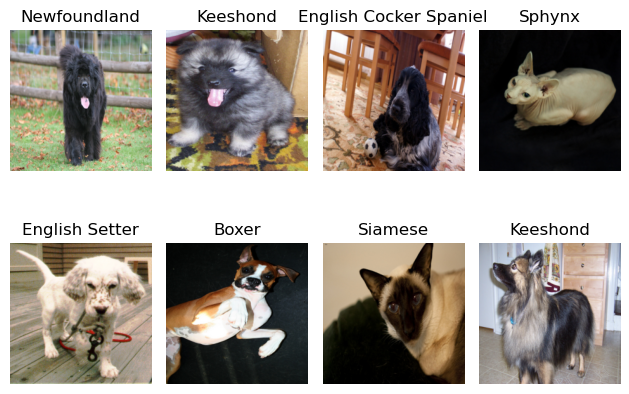

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

def unnormalize(image, mean, std):
    image = image.clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: x = x * std + mean
    return image

images, labels = next(iter(valid_loader))
print("Min pixel value ", images[0].min().item() )
print("Max pixel value ", images[0].max().item() )
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
image_1 = unnormalize(images[0], mean, std)
print("Min pixel value ", image_1.min().item() )
print("Max pixel value ", image_1.max().item() )
num_imgs_to_show = min(len(images), 8)
for i in range(num_imgs_to_show):
    plt.subplot(2, 4, i+1)
    img = unnormalize(images[i], mean, std)
    img = F.to_pil_image(img.clamp(0,1))
    plt.imshow(img)
    plt.title(f"{classes[labels[i].item()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [14]:
def get_preds(model, dataloader, device):

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)

            all_preds.append(outputs)
            all_targets.append(targets)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    return all_preds, all_targets

In [16]:
preds, targets = get_preds(model, valid_loader, mps_device)
#preds[0]

probs = torch.softmax(preds, dim=1)
print(probs)


tensor([[2.6080e-06, 2.7980e-06, 1.3539e-06,  ..., 1.5852e-11, 8.9040e-12,
         7.3181e-11],
        [4.8121e-07, 2.6227e-07, 2.0685e-07,  ..., 7.1151e-13, 8.3512e-12,
         4.3240e-11],
        [2.2525e-07, 2.9476e-06, 9.1746e-07,  ..., 7.9476e-11, 6.3054e-11,
         1.6909e-10],
        ...,
        [7.7184e-01, 1.9321e-04, 3.5437e-05,  ..., 1.1758e-11, 1.3532e-09,
         9.6763e-11],
        [3.9106e-02, 3.4208e-04, 1.6403e-03,  ..., 1.1218e-09, 8.5120e-09,
         7.2814e-09],
        [9.2009e-09, 1.1023e-06, 2.1791e-06,  ..., 7.8236e-14, 1.5260e-11,
         2.8462e-14]], device='mps:0')


In [17]:
probs[0].sum()

tensor(1.0000, device='mps:0')

In [43]:
for epoch in range(2):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, mps_device)
    val_loss, val_acc, val_error_rate = validate(model, valid_loader, criterion, mps_device)
    print(f"Epoch [{epoch+1}/2]: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val Error Rate={val_error_rate:.4f}")

100%|██████████| 92/92 [00:28<00:00,  3.21it/s]


Epoch [1/2]: Train Loss=0.1620, Train Acc=0.9511, Val Loss=0.3624, Val Acc=0.8954, Val Error Rate=0.1046


100%|██████████| 92/92 [00:28<00:00,  3.21it/s]


Epoch [2/2]: Train Loss=0.1345, Train Acc=0.9609, Val Loss=0.4846, Val Acc=0.8614, Val Error Rate=0.1386


In [21]:
pred_labels = torch.argmax(preds, dim=1)

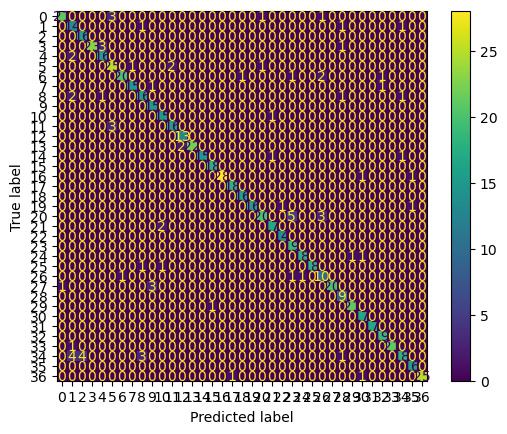

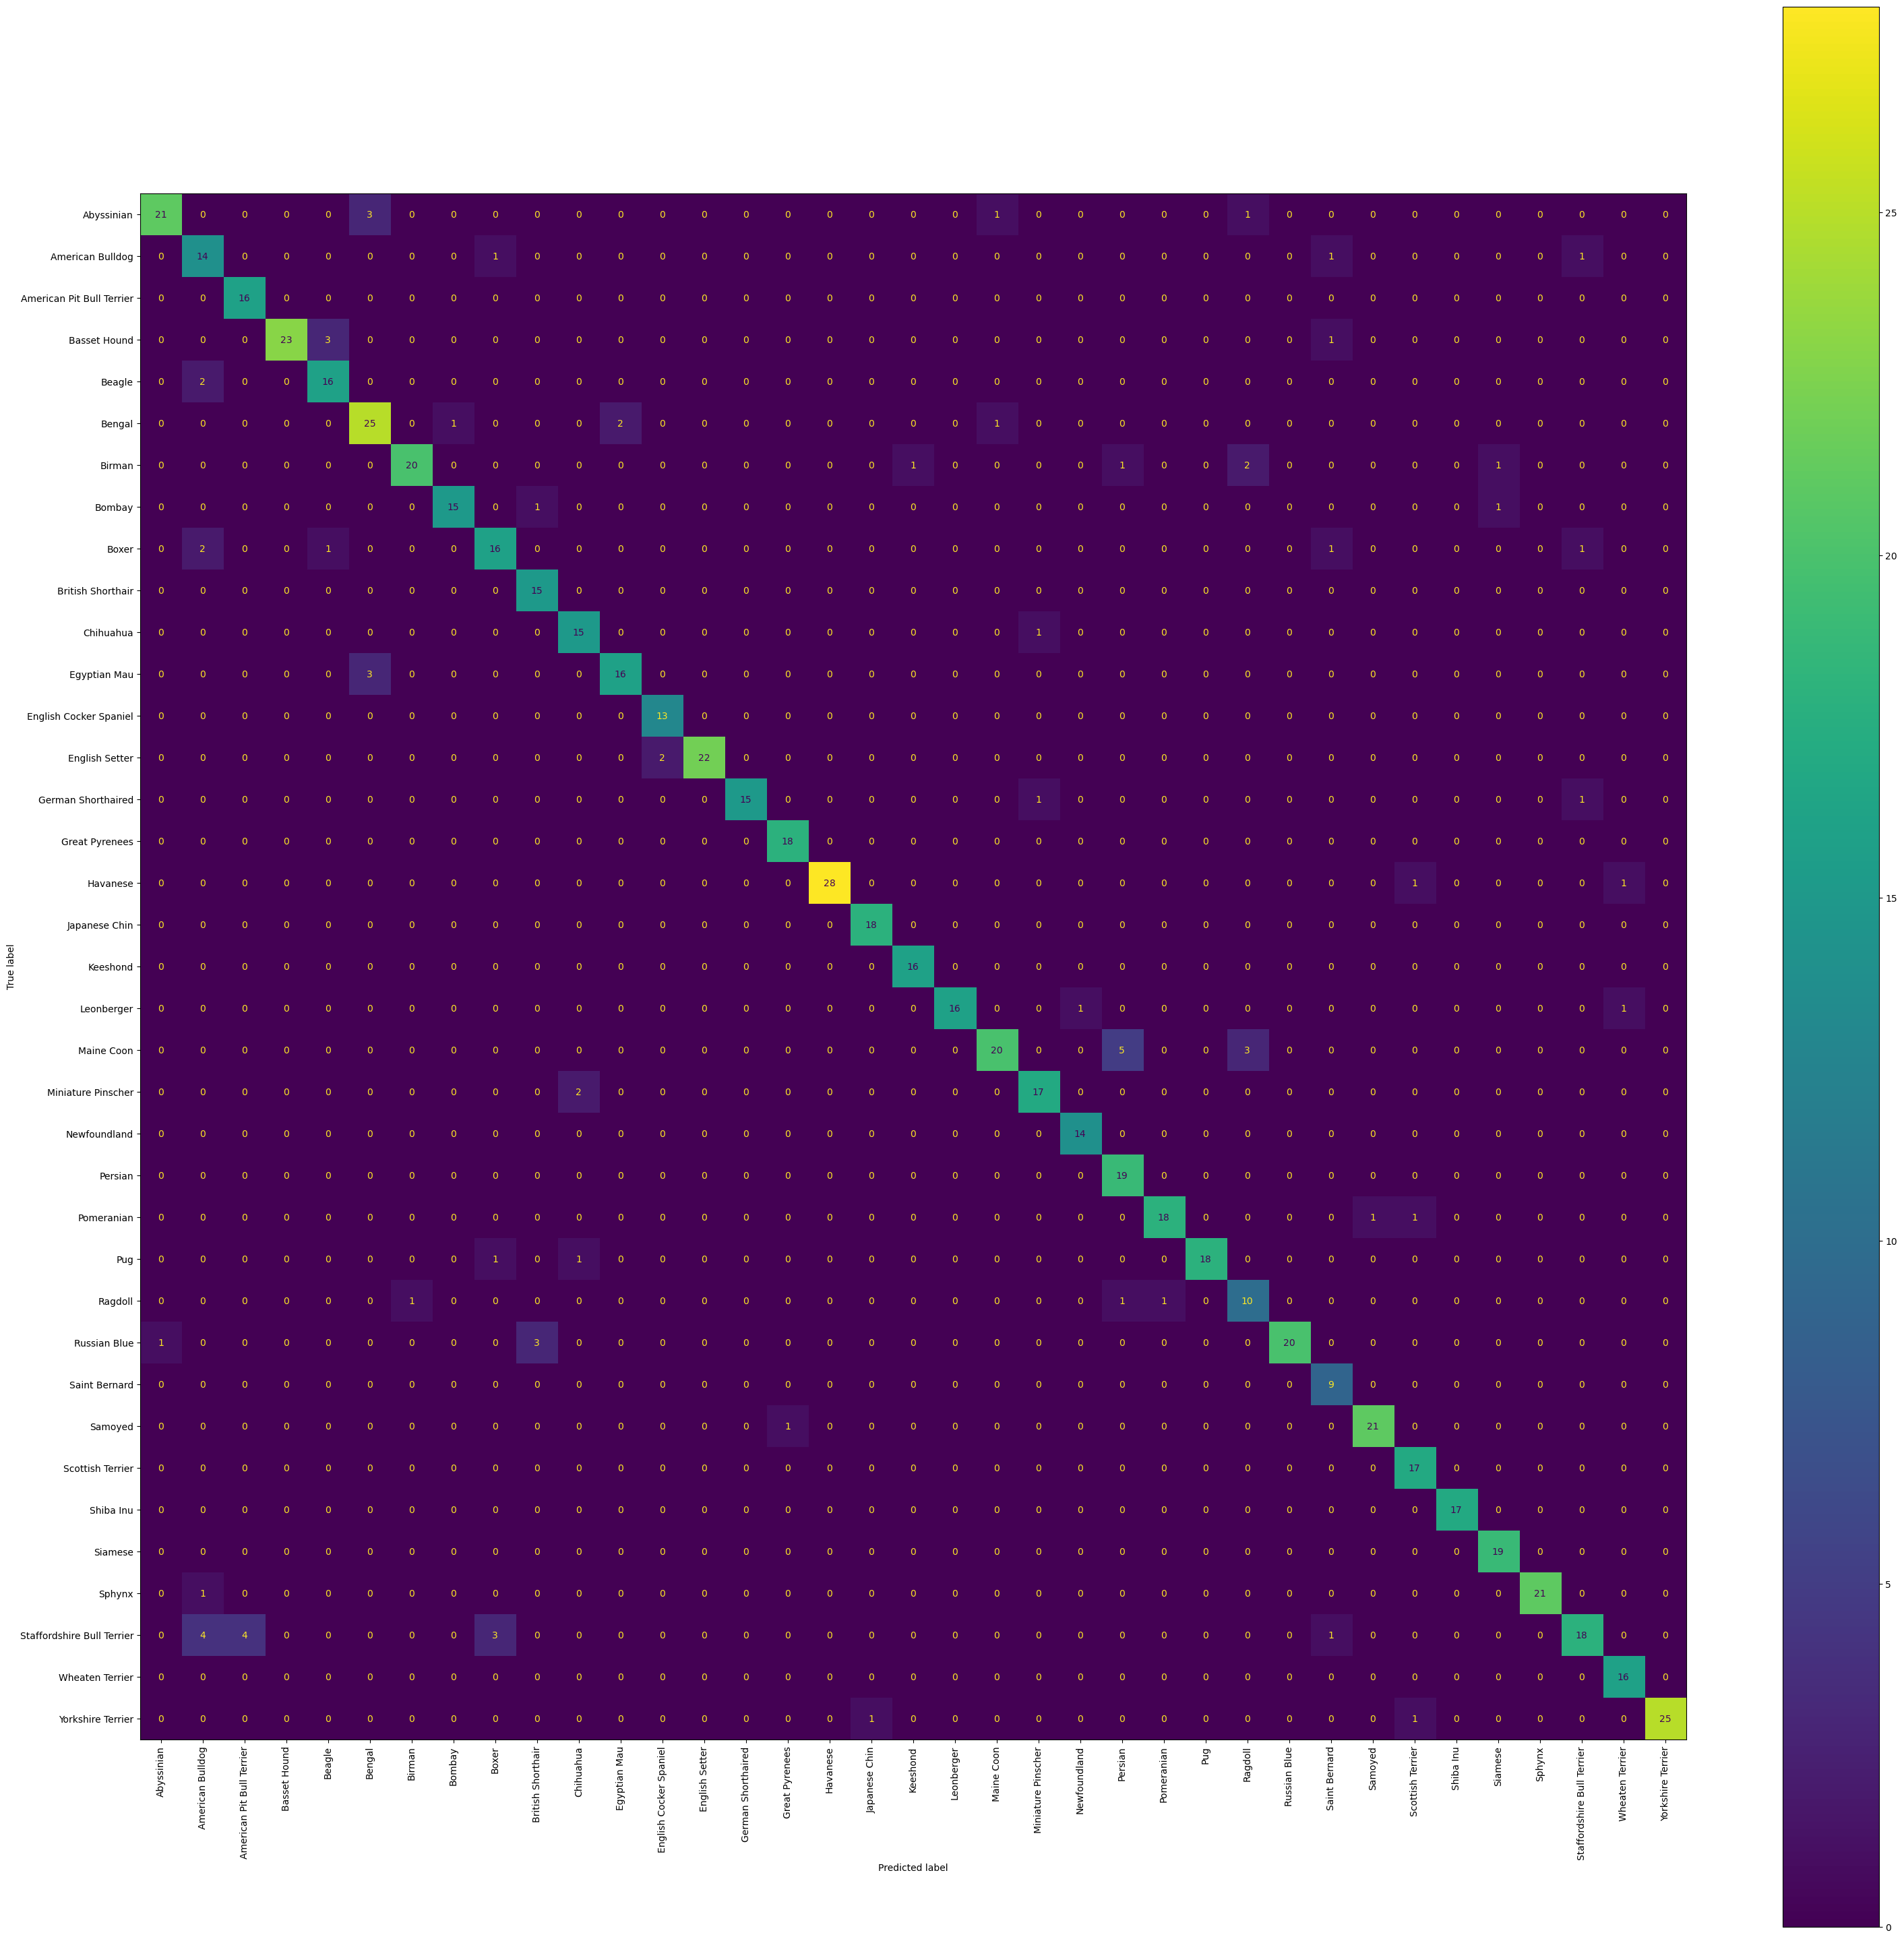

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(pred_labels.cpu().numpy(), targets.cpu().numpy())
ConfusionMatrixDisplay(cm).plot()

fig, ax = plt.subplots(figsize=(37, 37))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax = ax, cmap='viridis')
plt.xticks(rotation=90)
plt.show()

In [31]:
import numpy as np

confusion_indices = np.dstack(np.unravel_index(np.argsort(-cm, axis=None), cm.shape))[0]

confusion_indices = [(i, j) for i,j in confusion_indices if i!=j]

top_5_confusions = confusion_indices[:5]
top_5_counts = [cm[i, j] for i,j in top_5_confusions]

for (i, j), count in zip(top_5_confusions, top_5_counts):
    true_class = classes[i] if classes else i
    predicted_class = classes[j] if classes else j
    print(f"True Class: {true_class}, Predicted Class: {predicted_class}, Count: {count}")

True Class: Maine Coon, Predicted Class: Persian, Count: 5
True Class: Staffordshire Bull Terrier, Predicted Class: American Bulldog, Count: 4
True Class: Staffordshire Bull Terrier, Predicted Class: American Pit Bull Terrier, Count: 4
True Class: Basset Hound, Predicted Class: Beagle, Count: 3
True Class: Staffordshire Bull Terrier, Predicted Class: Boxer, Count: 3


In [53]:
#Learning Rate Finder

class LRFinder:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.history = {"lr": [], "loss": []}

    def find_lr(self, train_loader, start_lr = 1e-8, end_lr = 10, num_iter=100):
        self.model.train()
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lr_lambda=lambda x: (end_lr/start_lr) ** (x / num_iter)
        )

        for i, (inputs, targets) in enumerate(train_loader):
            if i>=num_iter:
                break

            inputs, targets = inputs.to(self.device), targets.to(self.device)

            lr_scheduler.step()
            current_lr = self.optimizer.param_groups[0]["lr"]

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)

            self.history["lr"].append(current_lr)
            self.history["loss"].append(loss.item())

            loss.backward()
            self.optimizer.step()

    def plot(self, skip_start = 10, skip_end = 5):
        lrs = self.history["lr"]
        losses = self.history["loss"]
        plt.plot(lrs[skip_start:-skip_end], losses[skip_start:-skip_end])
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        plt.title("Learning rate Finder")
        plt.show()


In [66]:
lr_finder = LRFinder(model, optimizer, criterion, mps_device)

In [67]:
lr_finder.find_lr(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)

/Users/aakashl/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


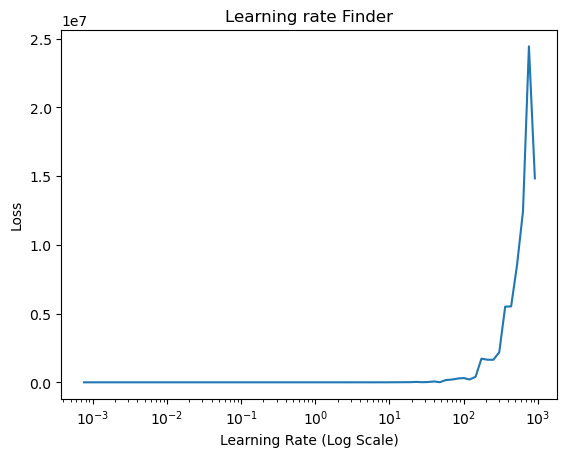

In [68]:
lr_finder.plot()